In [1]:
import einops
import numpy as np
import random
import torch
from PIL import Image
import os
from pytorch_lightning import seed_everything
from PTDiffusion.tools import create_model, load_state_dict
from PTDiffusion.phase_guided_sampler import Phase_Guided_Sampler
import torchvision.transforms
from IPython.display import display

/home/kemove/anaconda3/envs/controlnet/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
# resolution of the generated image
H = W = 512
# guidance scale of the classifier-free guidance
unconditional_guidance_scale = 7.5
# set sampling steps
denoising_steps = 100
# load the model
model = create_model('models/model_ldm_v15.yaml').cuda()
model.load_state_dict(load_state_dict('models/v1-5-pruned-emaonly.ckpt', location='cuda'), strict=False)
sampler = Phase_Guided_Sampler(model)
sampler.make_schedule(ddim_num_steps=denoising_steps)

LDMWrapper: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...


/home/kemove/anaconda3/envs/controlnet/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Loaded model config from [models/model_ldm_v15.yaml]
Loaded state_dict from [models/v1-5-pruned-emaonly.ckpt]
Selected timesteps for ddim sampler: [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530
 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710
 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890
 900 910 920 930 940 950 960 970 980 990]
Selected alphas for ddim sampler: a_t: tensor([0.9991, 0.9904, 0.9813, 0.9718, 0.9619, 0.9516, 0.9409, 0.9298, 0.9183,
        0.9065, 0.8942, 0.8816, 0.8687, 0.8554, 0.8418, 0.8278, 0.8136, 0.7990,
        0.7842, 0.7690, 0.7537, 0.7381, 0.7223, 0.7063, 0.6901, 0.6738, 0.6573,
        0.6407, 0.6241, 0.6073, 0.5905, 0.5737, 0.5568, 0.5400, 0.5232, 0.5065,
        0.4898, 0.4733, 0.4569, 0.4406, 0.4245, 0.4086, 0.3928, 0.3773, 0.3621,
       

/home/kemove/code_proj/PTDiffusion/ldm/modules/diffusionmodules/util.py:81: RuntimeWarning: invalid value encountered in sqrt
  sigmas = eta * np.sqrt((1 - alphas_next) / (1 - alphas) * (1 - alphas / alphas_next))


In [3]:
def set_random_seed(seed):
    if seed == -1:
        seed = random.randint(0, 65535)
    seed_everything(seed)

In [4]:
# function to load a reference image
def load_ref_img(img_path, contrast=2., add_noise=False, noise_value=0.05):
    img = Image.open(img_path).resize((W, H))
    img = img.convert("RGB")
    img = torchvision.transforms.ColorJitter(contrast=(contrast, contrast))(img)
    img = np.array(img)
    if len(img.shape) == 2:
        img = np.stack([img, img, img], axis=-1)
    img = (img.astype(np.float32) / 127.5) - 1.0           # -1 ~ 1
    img_tensor = torch.from_numpy(img).permute(2, 0, 1)[None, ...].cuda()   # 1, 3, 512, 512
    if add_noise:
        noise = (torch.rand_like(img_tensor) - 0.5) / 0.5      # -1 ~ 1
        img_tensor = (1 - noise_value) * img_tensor + noise_value * noise
    return img_tensor

In [5]:
def inversion(img_tensor):
    if os.path.exists('latent.py'):
        os.remove('latent.py')
    encoder_posterior = model.encode_first_stage(img_tensor)
    z = model.get_first_stage_encoding(encoder_posterior).detach()
    un_cond = {"c_crossattn": [model.get_learned_conditioning([''])]}
    latent = sampler.inversion(x0=z, cond=un_cond, t_inv=denoising_steps)
    torch.save(latent, 'latent.pt')

In [6]:
def load_inverted_noise():
    return torch.load('latent.pt').cuda()

In [7]:
def sample_illusion_image(latent, text_prompt, denoising_steps=100, direct_transfer_steps=60, decayed_transfer_steps=0,
                          async_ahead_steps=0, exponent=0.5):
    un_cond = {"c_crossattn": [model.get_learned_conditioning([''])]}
    cond = {"c_crossattn": [model.get_learned_conditioning([text_prompt])]}
    x_rec = sampler.decode_with_phase_substitution(ref_latent=latent, cond=cond, t_dec=denoising_steps,
                                                   unconditional_guidance_scale=unconditional_guidance_scale,
                                                   unconditional_conditioning=un_cond, direct_transfer_steps=direct_transfer_steps,
                                                   blending_ratio=0,
                                                   decayed_transfer_steps=decayed_transfer_steps, async_ahead_steps=async_ahead_steps,
                                                   exponent=exponent)
    x_sample = torch.clip(model.decode_first_stage(x_rec), min=-1, max=1).squeeze()
    x_sample = (einops.rearrange(x_sample, 'c h w -> h w c') * 127.5 + 127.5).cpu().numpy().astype(np.uint8)
    return x_sample

In [8]:
def img_show(sample):
    display(Image.fromarray(sample))

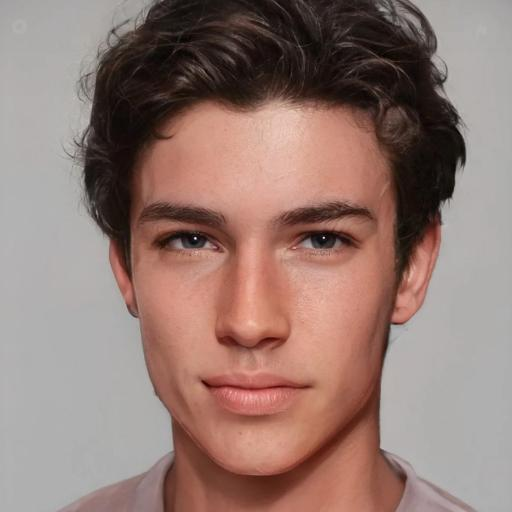

In [9]:
# show a reference image
display(Image.open('test_img/face1.jpg'))

In [10]:
# load a reference image and run inversion
inversion(load_ref_img('test_img/face1.jpg', contrast=2, add_noise=False))

Running DDIM inversion with 100 timesteps


Decoding image: 100%|█████████████████████████| 100/100 [00:08<00:00, 11.74it/s]


In [11]:
# generate an illusion picture      
set_random_seed(20)           
sample = sample_illusion_image(latent=load_inverted_noise(), direct_transfer_steps=40, decayed_transfer_steps=20, text_prompt='ancient ruins')      

Global seed set to 20


Running DDIM Sampling with 100 timesteps


Decoding image in the stage of direct phase transfer:   0%| | 0/40 [00:00<?, ?it
Decoding image in the stage of decayed phase transfer:   0%| | 0/20 [00:00<?, ?i

Decoding image in the stage of direct phase transfer: 100%|█| 40/40 [00:08<00:00

Decoding image in the stage of decayed phase transfer:   5%| | 1/20 [00:09<02:51
Decoding image in the stage of decayed phase transfer:  10%| | 2/20 [00:09<01:09
Decoding image in the stage of decayed phase transfer:  15%|▏| 3/20 [00:09<00:37
Decoding image in the stage of decayed phase transfer:  20%|▏| 4/20 [00:09<00:22
Decoding image in the stage of decayed phase transfer:  25%|▎| 5/20 [00:09<00:14
Decoding image in the stage of decayed phase transfer:  30%|▎| 6/20 [00:10<00:10
Decoding image in the stage of decayed phase transfer:  35%|▎| 7/20 [00:10<00:07
Decoding image in the stage of decayed phase transfer:  40%|▍| 8/20 [00:10<00:05
Decoding image in the stage of decayed phase transfer:  45%|▍| 9/20 [00:10<00:04
Decoding image in the stag

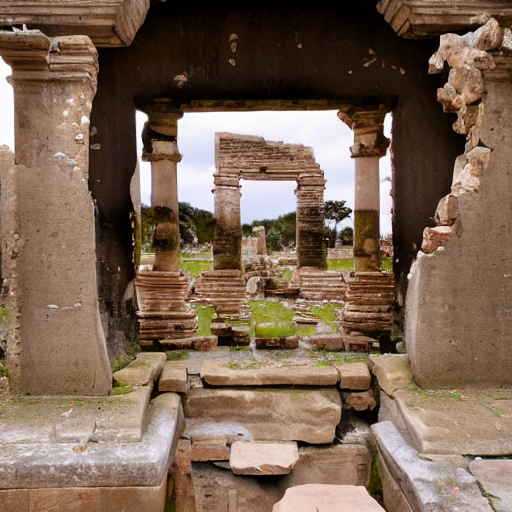

In [12]:
img_show(sample)  

In [13]:
# reset random seed to generate another sample, do not need to run inversion again for the same reference image
set_random_seed(2000)           
sample = sample_illusion_image(latent=load_inverted_noise(), direct_transfer_steps=40, decayed_transfer_steps=20, text_prompt='ancient ruins') 

Global seed set to 2000


Running DDIM Sampling with 100 timesteps


Decoding image in the stage of direct phase transfer:   0%| | 0/40 [00:00<?, ?it
Decoding image in the stage of decayed phase transfer:   0%| | 0/20 [00:00<?, ?i

Decoding image in the stage of direct phase transfer: 100%|█| 40/40 [00:08<00:00

Decoding image in the stage of decayed phase transfer:   5%| | 1/20 [00:09<02:51
Decoding image in the stage of decayed phase transfer:  10%| | 2/20 [00:09<01:09
Decoding image in the stage of decayed phase transfer:  15%|▏| 3/20 [00:09<00:37
Decoding image in the stage of decayed phase transfer:  20%|▏| 4/20 [00:09<00:22
Decoding image in the stage of decayed phase transfer:  25%|▎| 5/20 [00:09<00:14
Decoding image in the stage of decayed phase transfer:  30%|▎| 6/20 [00:10<00:10
Decoding image in the stage of decayed phase transfer:  35%|▎| 7/20 [00:10<00:07
Decoding image in the stage of decayed phase transfer:  40%|▍| 8/20 [00:10<00:05
Decoding image in the stage of decayed phase transfer:  45%|▍| 9/20 [00:10<00:04
Decoding image in the stag

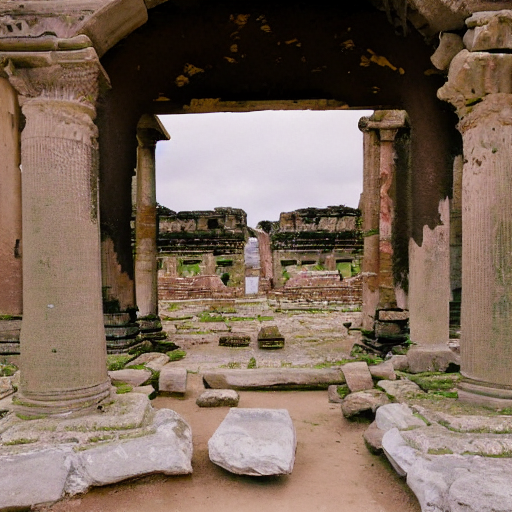

In [14]:
img_show(sample) 

In [15]:
# reset random seed to generate another sample, do not need to run inversion again for the same reference image
set_random_seed(6000)           
sample = sample_illusion_image(latent=load_inverted_noise(), direct_transfer_steps=40, decayed_transfer_steps=20, text_prompt='ancient ruins') 

Global seed set to 6000


Running DDIM Sampling with 100 timesteps


Decoding image in the stage of direct phase transfer:   0%| | 0/40 [00:00<?, ?it
Decoding image in the stage of decayed phase transfer:   0%| | 0/20 [00:00<?, ?i

Decoding image in the stage of direct phase transfer: 100%|█| 40/40 [00:08<00:00

Decoding image in the stage of decayed phase transfer:   5%| | 1/20 [00:09<02:52
Decoding image in the stage of decayed phase transfer:  10%| | 2/20 [00:09<01:09
Decoding image in the stage of decayed phase transfer:  15%|▏| 3/20 [00:09<00:37
Decoding image in the stage of decayed phase transfer:  20%|▏| 4/20 [00:09<00:22
Decoding image in the stage of decayed phase transfer:  25%|▎| 5/20 [00:09<00:14
Decoding image in the stage of decayed phase transfer:  30%|▎| 6/20 [00:10<00:10
Decoding image in the stage of decayed phase transfer:  35%|▎| 7/20 [00:10<00:07
Decoding image in the stage of decayed phase transfer:  40%|▍| 8/20 [00:10<00:05
Decoding image in the stage of decayed phase transfer:  45%|▍| 9/20 [00:10<00:04
Decoding image in the stag

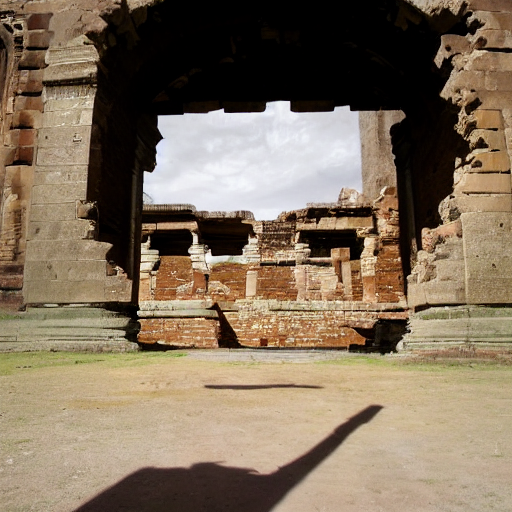

In [16]:
img_show(sample) 

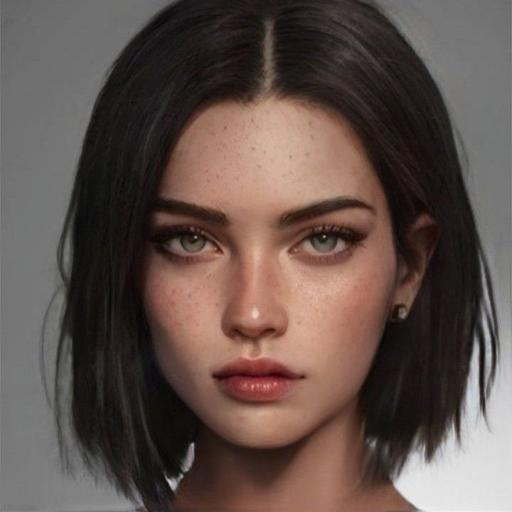

In [17]:
# test another reference image
# show the reference image
display(Image.open('test_img/face2.jpg'))

In [18]:
# load a new reference image and run the inversion
set_random_seed(100000)
inversion(load_ref_img('test_img/face2.jpg', contrast=5, add_noise=True, noise_value=0.1))

Global seed set to 100000


Running DDIM inversion with 100 timesteps


Decoding image: 100%|█████████████████████████| 100/100 [00:08<00:00, 11.65it/s]


In [19]:
# generate an illusion picture
set_random_seed(100000)
sample = sample_illusion_image(latent=load_inverted_noise(), direct_transfer_steps=40, decayed_transfer_steps=25, text_prompt='snow mountains')

Global seed set to 100000


Running DDIM Sampling with 100 timesteps


Decoding image in the stage of direct phase transfer:   0%| | 0/40 [00:00<?, ?it
Decoding image in the stage of decayed phase transfer:   0%| | 0/25 [00:00<?, ?i

Decoding image in the stage of direct phase transfer: 100%|█| 40/40 [00:08<00:00

Decoding image in the stage of decayed phase transfer:   4%| | 1/25 [00:09<03:38
Decoding image in the stage of decayed phase transfer:   8%| | 2/25 [00:09<01:29
Decoding image in the stage of decayed phase transfer:  12%| | 3/25 [00:09<00:48
Decoding image in the stage of decayed phase transfer:  16%|▏| 4/25 [00:09<00:29
Decoding image in the stage of decayed phase transfer:  20%|▏| 5/25 [00:10<00:19
Decoding image in the stage of decayed phase transfer:  24%|▏| 6/25 [00:10<00:13
Decoding image in the stage of decayed phase transfer:  28%|▎| 7/25 [00:10<00:10
Decoding image in the stage of decayed phase transfer:  32%|▎| 8/25 [00:10<00:07
Decoding image in the stage of decayed phase transfer:  36%|▎| 9/25 [00:10<00:06
Decoding image in the stag

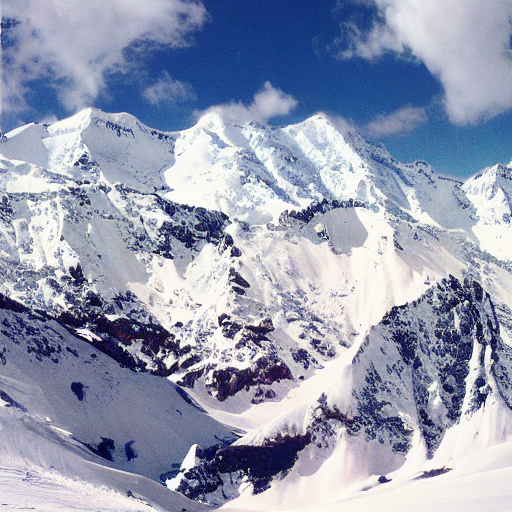

In [20]:
img_show(sample)